In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as Ft

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# import model from existing library
import sys
sys.path.append('PyTorch-VAE')
from models.vanilla_vae import VanillaVAE

In [2]:
dataset_name = 'celeba'  # either mnist or celeba

In [3]:
from pytorch_lightning.utilities.seed import seed_everything
seed = 55
seed_everything(seed)  # seed for reproducibility

Global seed set to 55


55

## Load pretrained model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get checkpoint from pretrained VAE model
version = 0
checkpoint = torch.load(f'PyTorch-VAE/logs/VanillaVAE/{dataset_name}/checkpoints/last.ckpt')
ckpt_state_dict = checkpoint['state_dict'].copy()
for key in checkpoint['state_dict']:
    ckpt_state_dict[key.replace('model.', '')] = ckpt_state_dict.pop(key)

# intitialize and load pretrained model
if dataset_name == 'mnist':
    model = VanillaVAE(in_channels=1, latent_dim=64, input_dim=32).to(device)
elif dataset_name == 'celeba':
    model = VanillaVAE(in_channels=3, latent_dim=128, input_dim=64).to(device)
else:
    raise ValueError(f'No such VAE trained on dataset: {dataset_name}')

model.load_state_dict(ckpt_state_dict)
model.eval()
print(f'Model loaded on {device}')

Model loaded on cuda


## Define dataset and dataloader
Note that the transformations in `test_transforms` are only _base_ transformations (not related to the semantic perturbations we are interested in testing).

In [5]:
import torchvision
import torchvision.transforms as transforms

batch_size = 4

if dataset_name == 'mnist':
    test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    testset = torchvision.datasets.MNIST(root='PyTorch-VAE/Data', train=False, download=False, transform=test_transforms)
else:
    test_transforms = transforms.Compose([
        transforms.CenterCrop(148),
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    testset = torchvision.datasets.CelebA(root='PyTorch-VAE/Data', split='test', download=False, transform=test_transforms)

testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

## Define custom transformations
Overload existing PyTorch transforms with some custom options.

In [6]:
def rotate(image, angle):
    return Ft.affine(image, angle, (0, 0), 1, 0, Ft.InterpolationMode.BILINEAR)
def translate_x(image, tx):
    return Ft.affine(image, 0, (tx, 0), 1, 0, Ft.InterpolationMode.BILINEAR)
def translate_y(image, ty):
    return Ft.affine(image, 0, (0, -ty), 1, 0, Ft.InterpolationMode.BILINEAR)  # note negative here, since positive y-translation in PyTorch is *downwards*
def scale(image, sc):
    return Ft.affine(image, 0, (0, 0), sc, 0, Ft.InterpolationMode.BILINEAR)
def shear(image, sh):
    return Ft.affine(image, 0, (0, 0), 1, sh, Ft.InterpolationMode.BILINEAR)   # only shear in horizontal direction

def haze(image, hz):
    return (1 - hz) * image + hz

In [7]:
import numpy as np

# define quick utility function to visualize and save images
def imshow(img, fname=None, save=False):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if save:
        plt.savefig(fname, bbox_inches='tight', dpi=500)
    else:
        plt.show()

In [ ]:
save = False

# visualize a sample batch of images from dataset on different transformations

dataiter = iter(testloader)
images, _ = dataiter.next()

print('Original:')
imshow(torchvision.utils.make_grid(images, pad_value=1), f'original_{dataset_name}.png', save)

## AFFINE TRANSFORMS
print('Rotate:')
imshow(torchvision.utils.make_grid(rotate(images, 10), pad_value=1), f'rotate_{dataset_name}.png', save)
print('Translate X:')
imshow(torchvision.utils.make_grid(translate_x(images, 4), pad_value=1), f'tx_{dataset_name}.png', save)
print('Translate Y:')
imshow(torchvision.utils.make_grid(translate_y(images, 4), pad_value=1), f'ty_{dataset_name}.png', save)
print('Scale:')
imshow(torchvision.utils.make_grid(scale(images, 1.1), pad_value=1), f'scale_{dataset_name}.png', save)
print('Shear:')
imshow(torchvision.utils.make_grid(shear(images, 10), pad_value=1), f'shear_{dataset_name}.png', save)

## COLOR TRANSFORMS
print('Brightness:')
imshow(torchvision.utils.make_grid(Ft.adjust_brightness(images, 0.5), pad_value=1), f'brightness_{dataset_name}.png', save)
print('Contrast:')
imshow(torchvision.utils.make_grid(Ft.adjust_contrast(images, 1.5), pad_value=1), f'contrast_{dataset_name}.png', save)
print('Hue:')
imshow(torchvision.utils.make_grid(Ft.adjust_hue(images, -0.05), pad_value=1), f'hue_{dataset_name}.png', save)
print('Saturation:')
imshow(torchvision.utils.make_grid(Ft.adjust_saturation(images, 0.8), pad_value=1), f'saturation_{dataset_name}.png', save)

## BLURRING
print('Blur:')
imshow(torchvision.utils.make_grid(Ft.gaussian_blur(images, 3, (2, 2)), pad_value=1), f'blur_{dataset_name}.png', save)
print('Haze:')
imshow(torchvision.utils.make_grid(haze(images, 0.1), pad_value=1), f'haze_{dataset_name}.png', save)

## Compute per-image MSE loss
Loop through all images and get each image's MSE loss (averaged over each image's pixels).

In [8]:
# compute average mse loss *per-image*
def mse_loss(recons, images):
    losses = F.mse_loss(recons, images, reduction='none')
    return losses.sum(-1).sum(-1).sum(-1) / (images.size(-1) * images.size(-2) * images.size(-3))

In [9]:
max_losses = torch.tensor([0 for k in range(len(testset))])
runs = 10

batch_size = 128
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=4, pin_memory=True)

with torch.no_grad():
    for r in range(runs):
        losses = torch.tensor([0 for k in range(len(testset))])
        
        for i, (images, _) in enumerate(testloader):
            images = images.to(device)
            recons, _, _, _ = model(images)
            recons = recons.clip(0, 1)

            # calculate each image's average pixel mse loss
            loss = mse_loss(recons, images)

            if images.size(0) == batch_size:
                losses[batch_size * i : batch_size * (i + 1)] = loss
            else:
                losses[batch_size * i :] = loss
        
        max_losses = torch.maximum(max_losses, losses)

## Get images with highest k losses
Also visualizes the images along with their VAE reconstructions.

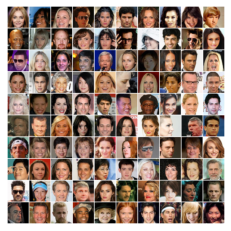

In [10]:
k = 100
high_loss_indices = torch.topk(max_losses, k)[1]
high_loss_dataset = torch.utils.data.Subset(testset, high_loss_indices)
loader = torch.utils.data.DataLoader(high_loss_dataset, k, shuffle=False, num_workers=4, pin_memory=True)
loader = iter(loader)
high_loss_images, _ = loader.next()
imshow(torchvision.utils.make_grid(high_loss_images.cpu(), nrow=10, pad_value=1))

## Run results for single perturbations

Compute and plot loss of MNIST images across shearing angle (Figure 1).

In [ ]:
# for visualizing variation in loss over shearing angles (Figure 1)

# plt.rc('axes', labelsize=16)
# plt.rc('xtick', labelsize=12)
# plt.rc('ytick', labelsize=12)
# plt.figure(dpi=500)

# with torch.no_grad():
#     for i in range(40, 60):
#         params = []
#         mses = []
#         for x in [-20 + 0.5*k for k in range(81)]:
#             perturbed_imgs = shear(images[i].unsqueeze(0), x)
#             recons, _, _, _ = model(perturbed_imgs)
#             recons = recons.clip(0, 1)
#             mses.append(F.mse_loss(recons, perturbed_imgs))
#             params.append(x)
#         plt.plot(params, mses)
# plt.xlabel('Shearing Angle (degrees)')
# plt.ylabel('Mean Squared Error')
# plt.savefig('results/nonuniform_loss.png', bbox_inches='tight', dpi=500)

Sample parameters for each perturbation and find the optimal parameter that leads to highest loss.

In [11]:
images = high_loss_images.to(device)
num_samples = 100

if dataset_name == 'mnist':
    transformations = [
        (Ft.adjust_brightness, [(0.5, 1.5)]),
        (Ft.adjust_contrast, [(0.5, 1.5)]),
        (rotate, [(-30, 30)]),
        (translate_x, [(-4, 4)]),
        (translate_y, [(-4, 4)]),
        (scale, [(0.9, 1.1)]),
        (shear, [(-20, 20)]),
        (Ft.gaussian_blur, [3, (0.05, 2.0)]),
        (haze, [(0, 0.1)])
    ]
elif dataset_name == 'celeba':
    transformations = [
        (Ft.adjust_brightness, [(0.5, 1.5)]),
        (Ft.adjust_contrast, [(0.5, 1.5)]),
        (rotate, [(-10, 10)]),
        (translate_x, [(-4, 4)]),
        (translate_y, [(-4, 4)]),
        (scale, [(0.9, 1.1)]),
        (shear, [(-10, 10)]),
        (Ft.gaussian_blur, [3, (0.05, 2.0)]),
        (Ft.adjust_saturation, [(0.8, 1.2)]),
        (Ft.adjust_hue, [(-0.05, 0.05)]),
        (haze, [(0, 0.1)])
    ]

all_losses = {}

with torch.no_grad():
    for (p, pe) in transformations:
        if len(pe) == 1:
            param_range = np.linspace(pe[0][0], pe[0][1], num=num_samples)
        else:
            param_range = np.linspace(pe[1][0], pe[1][1], num=num_samples)
        
        print(p.__name__, param_range[0], param_range[-1])
        
        chosen_params = []
        chosen_losses = []
        
        for i in range(100):
            max_param, max_mse = None, 0

            for x in param_range:
                if len(pe) == 1:
                    perturbed_imgs = p(images[i].unsqueeze(0), x)
                else:
                    perturbed_imgs = p(images[i].unsqueeze(0), pe[0], x)  # Gaussian blur
                    
                recons, _, _, _ = model(perturbed_imgs)
                recons = recons.clip(0, 1)
                loss = F.mse_loss(recons, perturbed_imgs).item()
                
                if loss > max_mse:
                    max_mse = loss
                    max_param = x
            
            chosen_params.append(max_param)
            chosen_losses.append(max_mse)
            
        all_losses[p.__name__] = (chosen_params, chosen_losses)

adjust_brightness 0.5 1.5
adjust_contrast 0.5 1.5
rotate -10.0 10.0
translate_x -4.0 4.0
translate_y -4.0 4.0
scale 0.9 1.1
shear -10.0 10.0
gaussian_blur 0.05 2.0
adjust_saturation 0.8 1.2
adjust_hue -0.05 0.05
haze 0.0 0.1


Compute loss statistics for the original images.

In [12]:
images = high_loss_images.to(device)

with torch.no_grad():
    recons, _, _, _ = model(images)
    recons = recons.clip(0, 1)
    losses = np.array(mse_loss(recons, images).cpu())
    losses *= 1000
    print(losses.min(), losses.mean(), losses.max(), losses.std())

4.2421713 13.076613 30.146223 5.189926


Compute loss statistics for the semantically perturbed images.

In [14]:
for perturbation, (params, losses) in all_losses.items():
    l = np.array(losses)
    l *= 1000
    m = round(l.mean(), 2)
    s = round(l.std(), 2)
    mn = round(l.min(), 2)
    mx = round(l.max(), 2)
    print(f'{perturbation} & {mn} & {m} & {mx} & {s} \\\\')

adjust_brightness & 9.07 & 22.86 & 57.57 & 8.42 \\
adjust_contrast & 9.8 & 23.75 & 57.26 & 9.17 \\
rotate & 8.44 & 24.0 & 46.17 & 8.41 \\
translate_x & 8.85 & 22.28 & 40.26 & 6.92 \\
translate_y & 8.65 & 23.85 & 40.97 & 6.38 \\
scale & 8.84 & 28.37 & 50.37 & 10.9 \\
shear & 7.74 & 21.7 & 40.08 & 7.13 \\
gaussian_blur & 7.46 & 15.37 & 33.35 & 5.25 \\
adjust_saturation & 7.53 & 16.42 & 36.05 & 5.7 \\
adjust_hue & 8.59 & 16.74 & 33.48 & 5.43 \\
haze & 6.9 & 15.49 & 31.52 & 4.98 \\


## Run results for compositions of perturbations (high-loss image generation algorithm)

In [15]:
from random import choice, uniform
from collections.abc import Iterable

def get_params(param_bounds):
    """
    Randomly generates parameters to be passed into transformation functions.

    @param param_bounds list[tuple[float, float] | int | float]
        if element is a 2-tuple, draws floating point number uniformly at random from an interval.
        The first element gives the lower bound of the interval; the second gives the upper bound.
        if element is a scalar value, selects that value for the parameter.
    @returns list[int | float]
        parameter values to be passed into transformation function
    """
    params = []
    for bound in param_bounds:
        if isinstance(bound, Iterable):
            params.append(uniform(*bound))
        else:
            params.append(bound)
    return params

In [16]:
import heapq
from scipy.stats import ttest_ind
from queue import Queue

if dataset_name == 'mnist':
    transformations = [
        (Ft.adjust_brightness, [(0.5, 1.5)]),
        (Ft.adjust_contrast, [(0.5, 1.5)]),
        (rotate, [(-30, 30)]),
        (translate_x, [(-4, 4)]),
        (translate_y, [(-4, 4)]),
        (scale, [(0.9, 1.1)]),
        (shear, [(-20, 20)]),
        (Ft.gaussian_blur, [3, (0.05, 2.0)]),
        (haze, [(0, 0.1)])
    ]
elif dataset_name == 'celeba':
    transformations = [
        (Ft.adjust_brightness, [(0.5, 1.5)]),
        (Ft.adjust_contrast, [(0.5, 1.5)]),
        (rotate, [(-10, 10)]),
        (translate_x, [(-4, 4)]),
        (translate_y, [(-4, 4)]),
        (scale, [(0.9, 1.1)]),
        (shear, [(-10, 10)]),
        (Ft.gaussian_blur, [3, (0.05, 2.0)]),
        (Ft.adjust_saturation, [(0.8, 1.2)]),
        (Ft.adjust_hue, [(-0.05, 0.05)]),
        (haze, [(0, 0.1)])
    ]

FAILURE_COUNT = 5
NUM_RUNS = 10
P_THRESHOLD = 0.05

base_images = high_loss_images.to(device)
high_loss_images = []

with torch.no_grad():

    # Push all the original images and their losses to the stack.
    recons, _, _, _ = model(base_images)
    recons = recons.clip(0, 1)
    base_losses = F.mse_loss(recons, base_images, reduction='none')
    stack = list(zip(
        [l.flatten().cpu().numpy() for l in base_losses], # loss
        [i.unsqueeze(0) for i in base_images],            # image itself
        [[] for i in range(len(base_images))],            # to store transformations on the image
        [i for i in range(len(base_images))]              # index of image
    ))

    while stack:
        original_loss, image, previous_transformations, image_index = stack.pop()
        num_failures = 0
        while num_failures != FAILURE_COUNT:
            # Get a transformation that hasn't already been used on the image.
            current_transformation = None
            while current_transformation is None or any(item[0].__name__ == current_transformation.__name__ for item in previous_transformations):
                current_transformation, bounds = choice(transformations)

            # Apply transformation.
            best_params = None
            max_avg_loss = 0
            new_loss = None
            new_image = None
            new_reconstruction = None
            for _ in range(NUM_RUNS):
                params = get_params(bounds)
                curr_image = current_transformation(image, *params)
                curr_reconstruction, _, _, _ = model(curr_image)
                curr_reconstruction = curr_reconstruction.clip(0, 1)
                curr_loss = F.mse_loss(curr_reconstruction, curr_image, reduction='none').flatten().cpu().numpy()
                if curr_loss.mean() > max_avg_loss:
                    best_params = params
                    max_avg_loss = curr_loss.mean()
                    new_loss = curr_loss
                    new_image = curr_image
                    new_reconstruction = curr_reconstruction

            # Add transformed image to list of base images, 
            # if loss has increased and more transformations can be applied
            # and loss increase is statistically significant.
            if new_loss.mean() > original_loss.mean() and ttest_ind(new_loss, original_loss).pvalue < P_THRESHOLD:
                applied_transformations = previous_transformations + [(current_transformation, best_params)]
                if len(transformations) != len(applied_transformations):
                    stack.append((new_loss, new_image, applied_transformations, image_index))
                high_loss_images.append((new_loss, new_image, new_reconstruction, applied_transformations, image_index))
                break
            else:
                num_failures += 1
                
high_loss_images = [(l.mean(), i, r, t, index) for (l, i, r, t, index) in high_loss_images]

Visualize and output results of algorithm.

Set 1:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 16.62415638566017, Loss (Perturbed): 79.57293838262558
---------------------------------------------------------------------------
Set 2:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 18.87309178709984, Loss (Perturbed): 78.207828104496
---------------------------------------------------------------------------
Set 4:
Original, Original Recons, Perturbed, Perturbed Recons:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss (Original): 11.03132963180542, Loss (Perturbed): 75.4610076546669
---------------------------------------------------------------------------
Set 6:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 28.22554111480713, Loss (Perturbed): 72.07173854112625
---------------------------------------------------------------------------
Set 7:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 10.504262521862984, Loss (Perturbed): 69.33467835187912
---------------------------------------------------------------------------
Set 9:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 17.229566350579262, Loss (Perturbed): 68.5424655675888
---------------------------------------------------------------------------
Set 10:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 8.052399381995201, Loss (Perturbed): 67.99637526273727
---------------------------------------------------------------------------
Set 12:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss (Original): 8.059179410338402, Loss (Perturbed): 61.2768679857254
---------------------------------------------------------------------------
Set 25:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 7.535423152148724, Loss (Perturbed): 60.719579458236694
---------------------------------------------------------------------------
Set 26:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 8.178099058568478, Loss (Perturbed): 58.939844369888306
---------------------------------------------------------------------------
Set 27:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 29.0994793176651, Loss (Perturbed): 58.2411102950573
---------------------------------------------------------------------------
Set 28:
Original, Original Recons, Perturbed, Perturbed Recons:
Loss (Original): 16.1859430372715, Loss (Perturbed): 58.21717157959938
---------------------------------------------------------------------------
Set 29

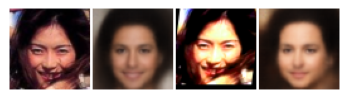

In [21]:
save = True

indices_observed = set()
original_losses = []
perturbed_losses = []

for idx, (loss, img, reconstruction, transformations, index) in enumerate(heapq.nlargest(100, high_loss_images)): 
    if index in indices_observed:
        continue
    
    indices_observed.add(index)
    
    print(f"Set {idx + 1}:")
    print("Original, Original Recons, Perturbed, Perturbed Recons:")
    orig_recons = torch.empty((4, *(img[0].shape)))
    orig_recons[2] = img.cpu()[0]
    orig_recons[3] = reconstruction.cpu()[0]
    orig_recons[0] = base_images[index].cpu()
    r, _, _, _ = model(base_images[index].unsqueeze(0))
    r = r.clip(0, 1)
    orig_recons[1] = r.cpu()
    
    original_loss = F.mse_loss(r, base_images[index]).item()
    original_losses.append(original_loss)
    perturbed_losses.append(loss)
    
    imshow(torchvision.utils.make_grid(orig_recons, pad_value=1), f'results/{dataset_name}/{dataset_name}_{idx + 1}.png', save)
    print(f'Loss (Original): {original_loss*1000}, Loss (Perturbed): {loss*1000}')
    print('---------------------------------------------------------------------------')
#     print("Transformations:")
#     print(transformations)
    
    if len(indices_observed) == 30:
        break

In [23]:
from scipy.stats import gmean

loss_increase = np.array(perturbed_losses) / np.array(original_losses)

print(gmean(loss_increase))
print((loss_increase).min())
print((loss_increase).max())

4.359194396657555
2.0014485365620103
8.444237802557842
